In [ ]:
# Installing dependencies for this notebook
%pip install einops moviepy proglog scikit-image

In [ ]:
import jax.numpy as jnp
from einops import rearrange
import numpy as np

In [3]:
from cglbm.lbm import grid_eq_dist, eq_dist_phase_field
from cglbm.simulation import multi_step_simulation
from cglbm.environment import State, System

In [4]:
from jax import config

# config.update("jax_debug_nans", True)
# config.update("jax_enable_x64", True)

# Simulation Code

## Density and Velocity update

### Notes about the functions

1. Every function is pure without side effects
2. They work for a single grid point
3. These functions will be vectorized to map over the entire grid


# Initial conditions


In [5]:
from cglbm.test_utils import load_config

system = load_config("params.ini")

## Phase Field

In [61]:
LX = system.LX
LY = system.LY
grid_shape = (LX, LY)

phase_field = jnp.zeros(grid_shape)

center = (LX/2, LY/2)
radius = system.drop_radius
Y, X = jnp.meshgrid(jnp.arange(LY), jnp.arange(LX))


### Initialising drop

drop = (X - center[0]) ** 2 + (Y - center[1]) ** 2 < radius ** 2

phase_field = phase_field.at[drop].set(1.0)

### Initialising drop with tanh

In [62]:
#### change to code when running
distanceFromCenter = jnp.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

# phase_field = 0.5 * (1.0 + jnp.tanh((distanceFromCenter - radius) * 2.0 / system.width))
phase_field = 0.0 * (1.0 + jnp.tanh((distanceFromCenter - radius) * 2.0 / system.width))

### Initialising square drop

#### change to code when running
side = min(LX, LY) / 2

square = jnp.logical_and(abs(X - center[0]) < side/2, abs(Y - center[1]) < side / 2)
phase_field = phase_field.at[square].set(1.0)

## Density, Velocity, Pressure

In [63]:
rho = system.density_one * phase_field + system.density_two * (1.0 - phase_field)
pressure = jnp.full(grid_shape, system.ref_pressure)

u_x = -system.uWallX + (Y - 2.5) * 2 * system.uWallX / (LY - 6)
u_y = jnp.zeros(grid_shape)
u = rearrange(jnp.stack([u_x, u_y]), "x i j -> i j x") #.transpose(1, 2, 0)

## Obstacle

In [64]:
obs = jnp.zeros(grid_shape, dtype=bool)
obs_velX = jnp.zeros(grid_shape)
obs_velY = jnp.zeros(grid_shape)

# cylinder = (X - center[0]) ** 2 + (Y - center[1]) ** 2 < radius ** 2
# obs = obs.at[cylinder].set(1.0)
# obs_velX = obs_velX.at[cylinder].set(system.uWallX)
# obs_velY = obs_velY.at[cylinder].set(system.uWallX)



# TODO: Find another way to set the obstacle
for i in range(system.LX):
    obs = obs.at[i, [0, 1, 2, -3, -2, -1]].set(True)
    obs_velX = obs_velX.at[i, [-3, -2, -1]].set(system.uWallX)
    obs_velX = obs_velX.at[i, [0, 1, 2]].set(-system.uWallX)

obs_vel = rearrange(jnp.stack([obs_velX, obs_velY]), "x i j -> i j x")

In [65]:
f = eq_dist_phase_field(system.cXYs, system.weights, phase_field, jnp.zeros((LX, LY, 2)))
N = grid_eq_dist(system.cXYs, system.weights, system.phi_weights, pressure, jnp.zeros((LX, LY, 2)))

In [66]:
state = State(
    rho=rho,
    pressure=pressure,
    u=u,
    obs=obs,
    obs_velocity=obs_vel,
    f=f,
    N=N
)

# Simulation

In [67]:
nr_iter = 10
nr_snapshots = 10
final_step = multi_step_simulation(system, state, nr_iter, nr_snapshots)

In [13]:
# %timeit multi_step_simulation(system, state, 1000, 100)

302 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Visualization

In [68]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import skimage.filters

ux_final, uy_final = rearrange(final_step["u"], "t i y x -> x t i y")#.transpose(3, 0, 1, 2)

# ux_final[:,obstacle] = 0
# uy_final[:,obstacle] = 0
vorticity = (
    np.roll(ux_final, -1, axis=1) - np.roll(ux_final, 1, axis=1)
) - (
    np.roll(uy_final, -1, axis=2) - np.roll(uy_final, 1, axis=2))

## Quiver Plot

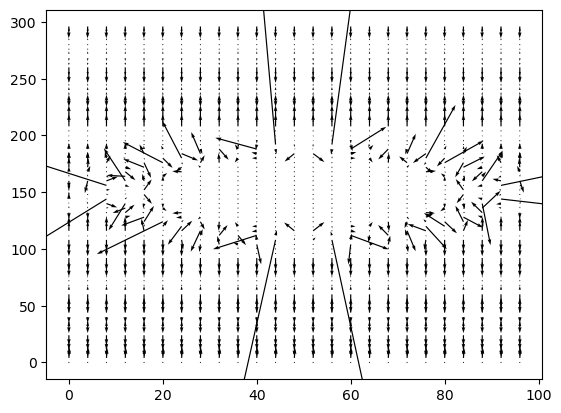

In [77]:
szx = LX
szy = LY
timestep = 5

# Plotting all the arrows will be messy so we are sampling one in every 16 points
skipx = 4
skipy = 4
x = np.arange(0,szx-1,skipx)
y = np.arange(0,szy-1,skipy)

yy, xx = jnp.meshgrid(y, x)

u = ux_final[timestep][:szx:skipx,:szy:skipy]
v = uy_final[timestep][:szx:skipx,:szy:skipy]

plt.quiver(xx, yy, u, v)

## Vorticity

0.018895553


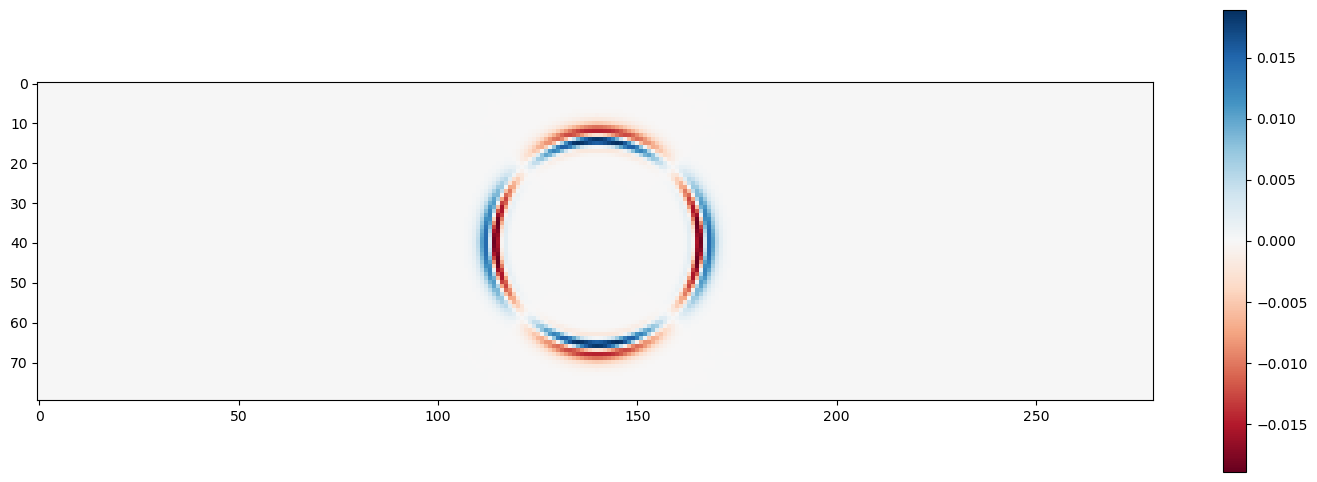

In [78]:
plt.figure(figsize=(18, 6))

frame = vorticity[1]

this_vmax = np.max(abs(frame))

print(this_vmax)

norm = clr.Normalize(vmin=-this_vmax, vmax=this_vmax)

# plt.axis('off')
plt.imshow(frame[10:-10, 10:-10], cmap='RdBu', norm=norm);
plt.colorbar()
# plt.clim(-.001, .001)

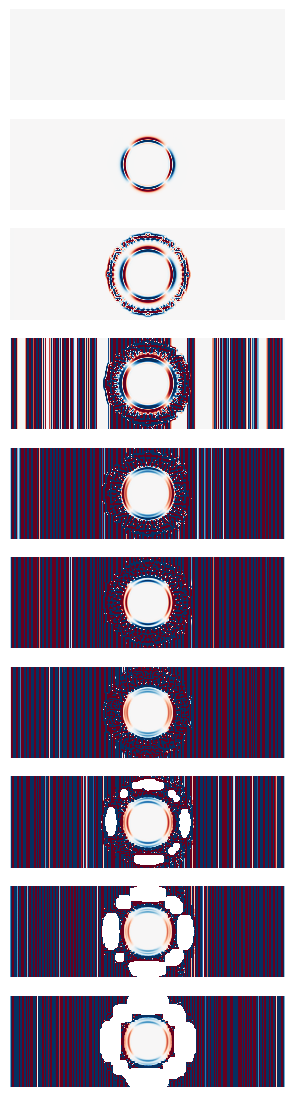

In [79]:
n = 10
samples = 100
fig, axes = plt.subplots(n, 1, figsize=(14, 14))
[ax.axis('off') for ax in axes]

# axes[0].cmap
# fig.colorbar()
axes[0].imshow(vorticity[0], cmap='RdBu', vmin=-0.01, vmax=0.01)
for i in range(min(n-1, len(vorticity)-1)):
    axes[i+1].imshow(vorticity[i + 1], cmap='RdBu', vmin=-0.01, vmax=0.01)

In [80]:
import matplotlib.cm
import matplotlib.colors
from PIL import Image

def make_images(data, cmap='RdBu', vmax=None):
    images = []
    for frame in data:
        if vmax is None:
            this_vmax = np.max(abs(frame))
        else:
            this_vmax = vmax
        norm = matplotlib.colors.Normalize(vmin=-this_vmax, vmax=this_vmax)
        mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
        rgba = mappable.to_rgba(frame, bytes=True)
        image = Image.fromarray(rgba, mode='RGBA')
        images.append(image)
    return images

def save_movie(images, path, duration=100, loop=0, **kwargs):
    images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)

images = make_images(vorticity, vmax=0.0001)


/Users/maneeshsutar/miniconda3/envs/dic/lib/python3.9/site-packages/matplotlib/colors.py:1354: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/Users/maneeshsutar/miniconda3/envs/dic/lib/python3.9/site-packages/matplotlib/colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


In [81]:
from functools import partial
import proglog
import skimage.filters
from moviepy.editor import ImageSequenceClip

# Show Movie
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip([np.array(im) for im in images], fps=2).ipython_display()

In [82]:
# save_movie(images,'wave_movie.gif', duration=[2000]+[200]*(len(images)-2)+[2000])